In [1]:
# Setup for Google Colab (optional)
import sys
if 'google.colab' in sys.modules:
    print("Running in Google Colab")
    # Install required packages
    !pip install -q py4DSTEM hyperspy scikit-image matplotlib numpy scipy
    
    # Clone the repository to access data
    !git clone -q https://github.com/NU-MSE-LECTURES/465-WINTER2026.git
    import os
    os.chdir('/content/465-WINTER2026')
    
    # Set up file handling
    from google.colab import files
    print("Colab setup complete!")
else:
    print("Running in local environment")

Running in local environment


<a href="https://colab.research.google.com/github/NU-MSE-LECTURES/465-WINTER2026/blob/main/Week_02/assignments/assignment_02_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 02: 4D-STEM Foundations

Complete this assignment to demonstrate your understanding of 4D-STEM data analysis and calibration.


In [2]:
# Colab setup
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab. Installing requirements...")
    !pip install hyperspy ase py4DSTEM
    !git clone https://github.com/NU-MSE-LECTURES/465_Computational_Microscopy_2026.git
    print("Setup complete.")
except ImportError:
    IN_COLAB = False
    print("Not running in Google Colab.")

Not running in Google Colab.


## Task 1: Distinguish Navigation vs. Signal Axes

In your notebook, define the "Navigation Axes" (where the measurement is made, e.g., x, y scan positions).

Define the "Signal Axes" (what is measured at each point, e.g., an EELS spectrum or a 2D diffraction pattern).

Use signal.axes manager to print and verify the dimensionality of a 4D-STEM dataset (expected: 2 Navigation, 2 Signal).

In [13]:
# Your code here
import hyperspy.api as hs

data = hs.load("Si-SiGe.dm4")

data = data.transpose(navigation_axes=[2,3],signal_axes=[0,1]) #Signal and Real Space measurements are flipped compared to expected

'Ky' == data.axes_manager.signal_axes[0].name
'Kx' == data.axes_manager.signal_axes[1].name
'Qy' == data.axes_manager.navigation_axes[0].name
'Qx' == data.axes_manager.navigation_axes[1].name

print(data.axes_manager) #Show Navigation and Signal Axes

# Define a Python class or functions to specify virtual detector geometries (e.g., Bright Field,
# Annular Dark Field, custom masks).
# Add a method to apply each virtual detector to a 4D-STEM data object and return a virtual
# image on the scan grid.
# Include checks to ensure all detector radii and positions lie within the detector reciprocal-
# space field of view.

def virtual_detector_application (dataset, mask, radius, center):
    """
    This function generates a virtual diffraction image based on inputted detector geometry.

    Args
    # dataset = 4DSTEM data in datacube form. Must be calibrated and pre-shifted if necessary.
    # mask = type of mask expressed as a string, either 'circle' (BF) or 'annular' (ADF)
    # radius = radius of mask in pixels. For BF, only one radius is needed, and for ADF, two radii are passed in as a tuple
    # center = center of the mask in pixels, entered as x, y coordinates in a tuple

    """
    #dataset = dataset.swap_RQ()
    data = dataset.data[...]
    shape = (data.shape[2], data.shape[3]) #[Qy, Qx]

    # Check detector radii and positions lie within detector-reciprocal space field of view
    if type(radius) == int:
        if radius > shape[0] or radius > shape[1]:
            print('The mask radius exceeds image size.')
            return
            
        
    elif type(radius) is not int:
        if any(x > y for x in radius for y in shape):
            print('One or both radii of the mask exceed image size.')
            return
            

        elif any(x > y for x in center for y in shape): 
            print('One or both center coordinates exceed image size.')
            return
            

    dataset.get_dp_mean()
    dataset.position_detector(mode=mask, geometry=(center, radius))
    generate_image = dataset.get_virtual_image(mode=mask, geometry=((center),radius))
    
    fig, ax = plt.subplots(1, 1)       
    im = ax.imshow(generate_image.data, cmap='magma')
    plt.colorbar(im, ax=ax)
    dx = float(dataset.calibration.get_R_pixel_size())     # e.g., nm per pixel
    units = dataset.calibration.get_R_pixel_units()  

    length_nm = dataset.shape[1] // 4
    length_px = length_nm / dx
    fontprops = fm.FontProperties(size=10)
    bar = AnchoredSizeBar(ax.transData, length_px, f"{length_nm:.0f} {units}",
                        loc='lower right', pad=0.2, color='black',
                        frameon=True, size_vertical=2, fontproperties=fontprops)
    ax.add_artist(bar)

    ax.set_ylabel(f'y ({units})', fontsize=12)
    ax.set_xlabel(f'x ({units})', fontsize=12)
    plt.tight_layout()
    if mask == 'circle':
        ax.set_title('Bright Field \n Image', fontsize=12)
    elif mask == 'annular':
        ax.set_title('Annular \n Dark Field \n Image', fontsize=12)

    return fig, ax



<Axes manager, axes: (17, 77|448, 480)>
            Name |   size |  index |  offset |   scale |  units 
================ | ====== | ====== | ======= | ======= | ====== 
               x |     17 |      0 |       0 |       2 |     nm 
               y |     77 |      0 |       0 |       2 |     nm 
---------------- | ------ | ------ | ------- | ------- | ------ 
               z |    448 |      0 |       0 |   0.062 |   1/nm 
     <undefined> |    480 |      0 |       0 |   0.062 |   1/nm 


## Task 2: Load and Calibrate 4D-STEM Data

Use py4DSTEM.io.read to load a 4D-STEM dataset (e.g., .dm4 or .h5).

**Note:** The dataset Si-SiGe.dm4 should be available in the raw_data folder.

Set the scan step size (real space calibration) using dataset.set_scan_step_size().

Perform Center of Mass (CoM) correction using dataset.get_diffraction_shifts() to center the unscattered beam.

In [4]:
# Your code here
# Calibration and Center of Mass (CoM) correction on real Si-SiGe dataset

# Set scan step size (real space calibration)
# For Si-SiGe dataset, typical step size is ~0.1 nm

def calc_com(dataset):
    
    step_size = 0.1 # in nm
    #print(f"Scan step size set to: {step_size} nm")

    # Store calibration metadata
    if hasattr(dataset, 'metadata'):
        dataset.metadata['scan_step_size_nm'] = step_size

    # print("\n--- Performing Center of Mass (CoM) Correction ---")
    # print("CoM correction centers the unscattered beam for each diffraction pattern")
    # print("This improves alignment and enables accurate analysis of crystal orientation.\n")

    # Compute center of mass shifts for all diffraction patterns
    # print("Computing center of mass for each diffraction pattern...")
    nav_shape = dataset.data.shape[2:] # Navigation dimensions (77, 17)
    sig_shape = dataset.data.shape[:2] # Signal dimensions (480, 448)

    # Create shift arrays
    shifts_x = np.zeros(nav_shape)
    shifts_y = np.zeros(nav_shape)

    copy = py4DSTEM.DataCube.copy(dataset)

    # Calculate CoM for each diffraction pattern
    for i in range(nav_shape[0]):
        for j in range(nav_shape[1]):
            dp = dataset.data[:, :, i, j]
            # Find center of mass
            y_coords, x_coords = np.mgrid[0:sig_shape[0], 0:sig_shape[1]]
            total_intensity = np.sum(dp)
            if total_intensity > 0:
                com_x = np.sum(x_coords * dp) / total_intensity
                com_y = np.sum(y_coords * dp) / total_intensity
                # Calculate shift from center
                center_x, center_y = sig_shape[1] / 2, sig_shape[0] / 2
                shift_x = com_x - center_x
                shift_y = com_y - center_y
                copy.data[:,:,i,j] = shift(dp, (shift_y, shift_x), order=1, mode='nearest', prefilter=False)

    return copy



In [5]:
def total_scattered_intensity(dataset):
    """
    Calculate the total scattered intensity of a diffraction pattern.

    dataset : datacube containing diffraction patterns

    Returns total_intensity as np array of floats containing total scattered intensity 
            of all diffraction patterns
    """

    dp = dataset.data[...]
    Ky, Kx, Qy, Qx = dp.shape
    total_inten = np.array([])

    # Total integrated scattered intensity
    for i in range(Qy):
        for j in range(Qx):
            ti = float(np.sum(dp[i,j,:,:]))
            total_inten = np.append(total_inten, ti)

    return total_inten



In [6]:
# radial intensity profiles from the diffraction patterns.

def radial_intensity_profiles(dataset):
    dp = np.mean(dataset.data[...], axis=(0, 1)).astype(float)
    print(dp.shape)
    threshold = np.percentile(dp, 99.5)
    high_intensity_mask = dp > threshold
    if high_intensity_mask.any():
        origin_y, origin_x = center_of_mass(dp * high_intensity_mask)
        print(f"Refined center from direct beam: ({origin_x:.2f}, {origin_y:.2f})")
    else:
        # Fallback to geometric center
        origin_x = dp.shape[0] / 2.0
        origin_y = dp.shape[1] / 2.0
        print(f"Using geometric center: ({origin_x:.2f}, {origin_y:.2f})")

    # Create coordinate grids
    y_coords, x_coords = np.ogrid[:dp.shape[0], :dp.shape[1]]
    r = np.sqrt((x_coords - origin_x)**2 + (y_coords - origin_y)**2)

    # Compute radial average
    r_int = r.astype(int)
    max_radius = int(np.sqrt(origin_x**2 + origin_y**2))
    radial_profile = np.zeros(max_radius)
    radial_counts = np.zeros(max_radius)

    for radius in range(max_radius):
        mask = r_int == radius
        if mask.any():
            radial_profile[radius] = dp[mask].mean()
            radial_counts[radius] = mask.sum()

    # Find peaks in radial profile
    from scipy.signal import find_peaks

    # Use find_peaks with relaxed parameters to catch more reflections
    peaks_radii, peak_properties = find_peaks(radial_profile, 
                                            height=np.percentile(radial_profile[5:], 93),  # Skip center
                                            distance=3,
                                            prominence=0.05)

    # Filter out peaks too close to center (direct beam)
    peaks_radii = peaks_radii[peaks_radii > 3]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Left plot: Diffraction pattern with radial rings at peak positions
    im = ax1.imshow(np.log1p(dp), cmap='gray', origin='upper')
    ax1.set_xlabel('Detector X (pixels)', fontsize=12)
    ax1.set_ylabel('Detector Y (pixels)', fontsize=12)
    ax1.set_title('Average Diffraction Pattern with Bragg Rings', fontsize=13)

    # Draw circles at detected peak radii
    theta = np.linspace(0, 2*np.pi, 100)
    for i, r_peak in enumerate(peaks_radii):
        x_circle = origin_x + r_peak * np.cos(theta)
        y_circle = origin_y + r_peak * np.sin(theta)
        ax1.plot(x_circle, y_circle, 'r-', linewidth=1.5, alpha=0.6, label=f'Ring {i+1}' if i < 3 else '')

    ax1.plot(origin_x, origin_y, 'b+', markersize=15, markeredgewidth=2, label='Center')
    ax1.legend(fontsize=9, loc='upper right')
    plt.colorbar(im, ax=ax1, label='Intensity (log scale)')

    # Right plot: Radial profile with detected peaks
    ax2.plot(radial_profile, 'k-', linewidth=1.5, label='Radial average')
    ax2.plot(peaks_radii, radial_profile[peaks_radii], 'ro', markersize=8, label='Detected peaks')
    ax2.set_xlabel('Radius (pixels)', fontsize=12)
    ax2.set_ylabel('Average Intensity', fontsize=12)
    ax2.set_title('Radial Profile with Bragg Peaks', fontsize=13)
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    ax2.set_xlim(0, max_radius)

    plt.tight_layout()
    plt.show()

    print(f"✓ Identified {len(peaks_radii)} Bragg reflections from radial profile")


In [7]:
def calibrate_data(filename):
    dataset = hs.load(filename)
    #dataset = dataset.transpose(navigation_axes=[2,3],signal_axes=[0,1])
    R_ps = dataset.axes_manager.signal_axes[0].scale
    R_pu = dataset.axes_manager.signal_axes[1].units
    Q_ps = dataset.axes_manager.navigation_axes[0].scale
    Q_pu = dataset.axes_manager.navigation_axes[1].units

    data = py4DSTEM.import_file(filename)
    data = data.swap_RQ()
    data.calibration.set_Q_pixel_size(Q_ps)
    if Q_pu == '1/nm':
        Q_ps = 0.1*Q_ps
        Q_pu = 'A^-1'
        data.calibration.set_Q_pixel_units(Q_pu)
    else:
        data.calibration.set_Q_pixel_units(Q_pu)

    data.calibration.set_R_pixel_size(R_ps)
    data.calibration.set_R_pixel_units(R_pu)

    return data


## Task 3: Virtual Detector Reconstruction

Generate a Virtual Bright Field (BF) image by integrating the central transmitted disk.

Generate an Annular Dark Field (ADF) image by integrating the scattered electrons in an outer ring.

Compare the Z-contrast in the ADF image to the diffraction contrast in the BF image.

In [8]:
def get_meta_value(dc, key: str, default = 'NOT FOUND'):

    """
    Return the value for `key` from a py4DSTEM/emdfile DataCube's metadata.

    Works whether `dc.metadata` is:
      - a single emdfile.Metadata (dict-like), or
      - a mapping of name -> emdfile.Metadata objects.
    """
    md = getattr(dc, "metadata", None)
    if md is None:
        return default

    # Case A: single Metadata (dict-like)
    # emdfile.Metadata supports .get and 'in'
    if hasattr(md, "get") and hasattr(md, "__contains__"):
        return md.get(key, default)

    # Case B: mapping of name -> Metadata
    items = getattr(md, "items", lambda: [])()
    for name, block in items:
        if hasattr(block, "get") and hasattr(block, "__contains__"):
            if key in block:
                return block.get(key, default)

    return default

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

def line_profile_virtual_detector(shifted, mask='circle', radius=None, center=None, col=None):
    """
    Build a virtual real-space image (BF/ADF) and plot a column (x=col) profile vs y.
    """

    # 1) Work on a Q-first view for virtual detector helpers
    ds = shifted  # -> (Qx, Qy, Rx, Ry)

    # 2) Default center in Q-space if not provided
    Qy, Qx, Ky, Kx, = ds.data.shape
  
    if center is None:
        center = (int(round((Ky - 1)/2)), int(round((Kx - 1)/2)))
    else:
        cy, cx = center
        if not (0 <= cx < Kx and 0 <= cy < Ky):
            raise ValueError(f"center {center} out of bounds for K shape {(Ky, Kx)}")

    # 3) Validate radius
    if mask == 'circle':
        if radius is None:
            radius = int(min(Ky, Kx) * 0.15)
        else:
            radius = int(radius)
        if not (radius > 0 and radius <= min(Kx, Ky)):
            raise ValueError(f"radius {radius} invalid for K shape {(Kx, Ky)}")
        geometry = (center, radius)
    elif mask == 'annular':
        if not (isinstance(radius, (tuple, list)) and len(radius) == 2):
            raise ValueError("For 'annular', radius must be a tuple like (r_in, r_out).")
        r_in, r_out = map(int, radius)
        if not (0 < r_in < r_out <= min(Kx, Ky)):
            raise ValueError(f"annular radii {radius} invalid for K shape {(Kx, Ky)}")
        geometry = (center, (r_in, r_out))
    else:
        raise ValueError("mask must be 'circle' or 'annular'.")

    # 4) Build virtual image (real space)
    vi = ds.get_virtual_image(mode=mask, geometry=geometry)
    # img = vi.data[Qy]                                    # SHAPE: (Qy, Qx)  <-- IMPORTANT
 

    #Rx, Ry = img.shape                               # (x, y) sizes from image

    # pick column; 0..Rx-1
    if col is None:
        col = Qx // 2
    if not (0 <= col < Qx):
        raise ValueError(f"col={col} out of bounds for image width Qx={Qx}")

    # column scan at fixed x=col → take all y
    profile = vi.data[:, col]                            # length = Ry

    # y‑axis in real units
    dx = float(ds.calibration.get_R_pixel_size())    # e.g., nm/px
    units = ds.calibration.get_R_pixel_units()
    y_axis = np.arange(Qy)                   # length = Ry  <-- matches profile

    # 5) Plot image + column profile
    fig, (ax_img, ax_prof) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

    # Display image (transpose for conventional orientation only)
    im = ax_img.imshow(
        vi.data, origin='upper', cmap='magma')
    ax_img.axvline(x=col, color='w', lw=1.2, alpha=0.9)
    cbar = plt.colorbar(im, ax=ax_img)
    cbar.set_label("Intensity (a.u.)")

    # Scale bar (~1/4 image width)
    length_real = (Qx * dx) / 4.0
    length_px   = length_real / dx
    fontprops = fm.FontProperties(size=10)
    bar = AnchoredSizeBar(ax_img.transData, length_px, f"{length_real:.0f} {units}",
                          loc='lower right', pad=0.2, color='black',
                          frameon=True, size_vertical=2, fontproperties=fontprops)
    ax_img.add_artist(bar)

    ax_img.set_xlabel(f"x ({units})")
    ax_img.set_ylabel(f"y ({units})")
    ax_img.set_title('Bright Field\nImage' if mask == 'circle' else 'Annular Dark Field\nImage')

    # Column profile (now lengths match)
    ax_prof.plot(y_axis, profile, '-k')
    ax_prof.set_xlabel(f"y ({units})")
    ax_prof.set_ylabel("Intensity (a.u.)")
    ax_prof.set_title(f"Column profile at x={col}{units}")
    ax_prof.grid(True, alpha=0.3)

    plt.show()
    return fig, ax_img, ax_prof

In [10]:
def run_pipeline(filename):
    dataset = hs.load(filename)
    calibrated = calibrate_data(filename)
    Qy, Qx, Ky, Kx = calibrated.shape
    shifted = calc_com(calibrated)
 
    radial_intensity_profiles(shifted)
    
    bf_fig, bf_ax = virtual_detector_application (shifted, 'circle', Ky//20, (Ky//2, Kx//2))
    adf_fig, adf_ax = virtual_detector_application (shifted, 'annular', (Ky//14.5,Ky//6.5), (Ky//2, Kx//2))  

    bf_fig.savefig('BrightFieldImage.png', bbox_inches='tight')
    adf_fig.savefig('AnnularDarkFieldImage.png', bbox_inches='tight') 

    scan_step = get_meta_value(shifted, "scan_step_size_nm")
    det_pix    = get_meta_value(shifted, "detector_pixel_size")
    cam_len    = get_meta_value(shifted, "camera_length")

    if scan_step is None:
        print("Missing scan step size.")
    if det_pix is None:
        print("Missing detector pixel size.")
    if cam_len is None:
        print("Missing camera length.")
    else:
        print("All required metadata present.")

    line_fig, ax_img, ax_prof = line_profile_virtual_detector(shifted, radius=Ky//17, mask = 'circle', center=(Ky//2, Kx//2))
    line_fig.savefig('Linescan Comparison.png', bbox_inches='tight')
    
    


## Task 4: Basic 4D-STEM Visualization

Launch the interactive 4D-STEM browser using dataset.show() (if using a local GUI) or py4D.show_image().

Export a publication-quality figure of a virtual ADF image with a scale bar and a perceptually uniform colormap (e.g., magma).

(480, 448)
Refined center from direct beam: (220.99, 245.13)


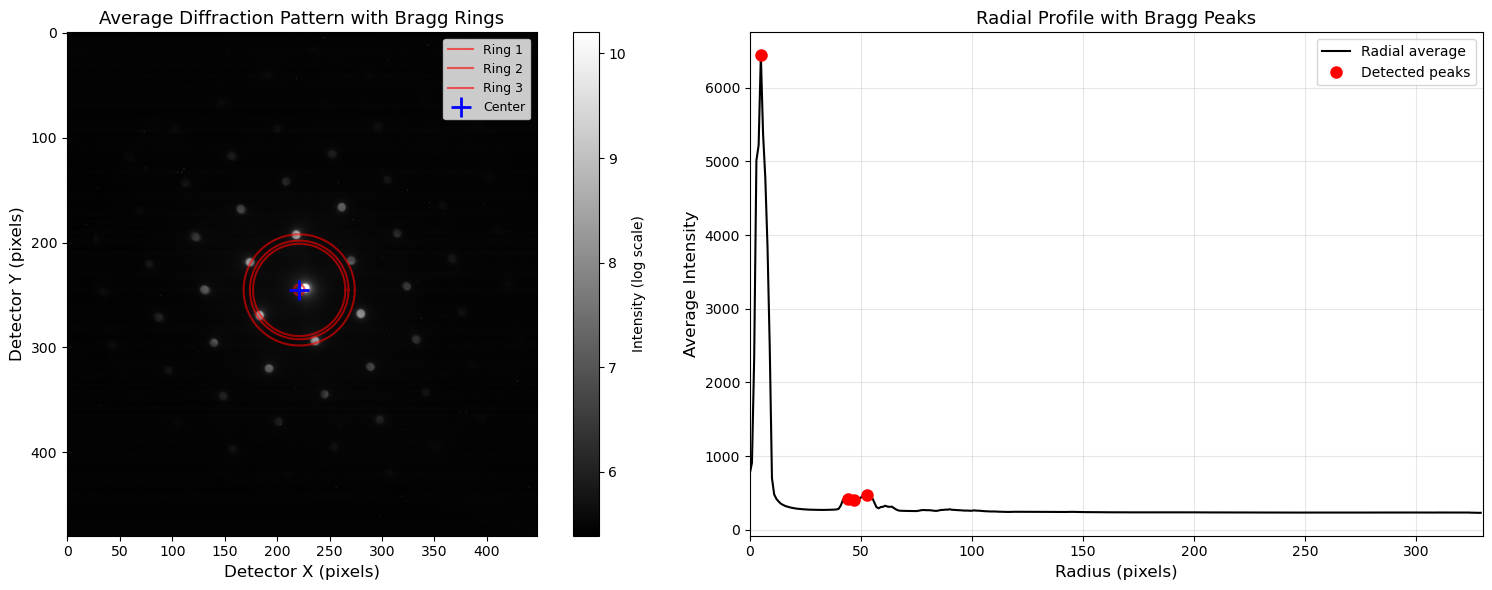

✓ Identified 4 Bragg reflections from radial profile


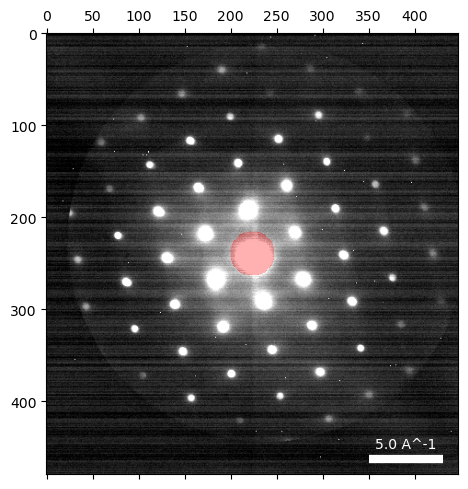

100%|██████████| 1309/1309 [00:00<00:00, 18375.51it/s]


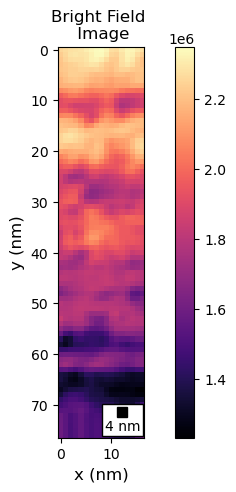

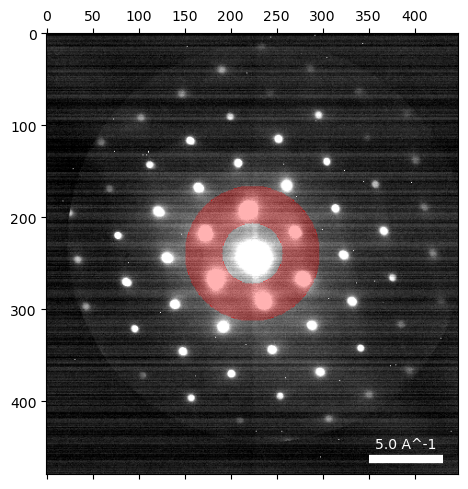

100%|██████████| 1309/1309 [00:00<00:00, 20929.23it/s]


All required metadata present.


100%|██████████| 1309/1309 [00:00<00:00, 20021.68it/s]


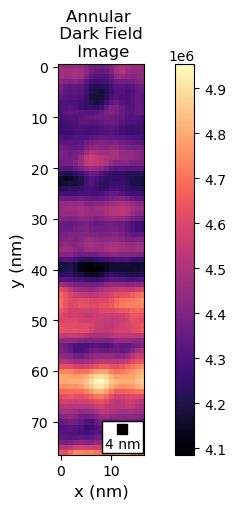

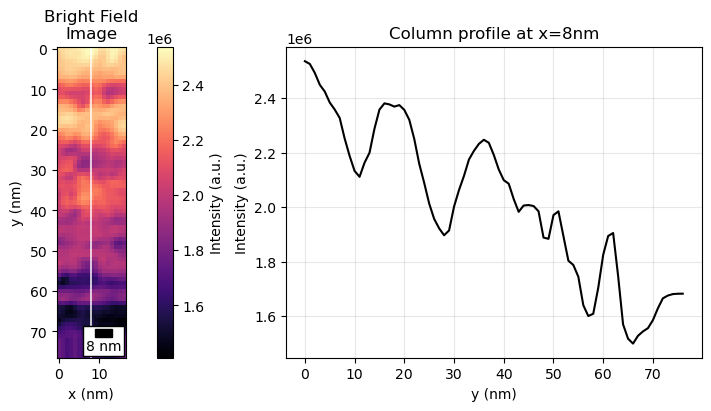

In [11]:
# Your code here

import py4DSTEM
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
from scipy.ndimage import center_of_mass, shift
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

run_pipeline("Si-SiGe.dm4")



## Task 5: Finalize and Submit

Update your README.md with a brief explanation of how virtual detectors allow post-acquisition imaging.

Push the completed Week 02 notebook to your GitHub repository.

Submit the repository link on Canvas.

In [12]:
# Your code here